In [32]:
import os
import pandas as pd
import numpy as np
from collections import defaultdict

In [3]:
directory_path = 'data'

all_data = []

# Iterate over all files in the directory
for filename in os.listdir(directory_path):
    # Check if the file is a text file
    if filename.endswith('.txt'):
      file_path = os.path.join(directory_path, filename)
      with open(file_path, 'r', encoding='utf-8') as file:
          content = file.read()
          number = filename[3:11]
          all_data.append((content, number))

# Convert the list into a DataFrame
df = pd.DataFrame(all_data, columns=['Content', 'Date'])
df.head()

,Content,Date
0,Hight News From Rices Religious Clubs By JOAN...,19540402
1,ihe two tilts ach between the Hig Coach Jimmy...,19341221
2,13% 11% 14% 12% 20% 2015 HOUS 2015 HOUSTTON E...,20151028
3,111 Student Weekly Publication The Rice In...,19410221
4,l/ fl New athletes show marked academic imp...,19840921


In [4]:
df.shape

(2760, 2)

In [5]:
df['Date'] = df['Date'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))

In [6]:
df['Year'] = df['Date'].dt.year

In [7]:
df.head()

,Content,Date,Year
0,Hight News From Rices Religious Clubs By JOAN...,1954-04-02,1954
1,ihe two tilts ach between the Hig Coach Jimmy...,1934-12-21,1934
2,13% 11% 14% 12% 20% 2015 HOUS 2015 HOUSTTON E...,2015-10-28,2015
3,111 Student Weekly Publication The Rice In...,1941-02-21,1941
4,l/ fl New athletes show marked academic imp...,1984-09-21,1984


In [8]:
articles_per_year = df.groupby('Year').size().reset_index(name='Number_of_Articles')
articles_per_year

,Year,Number_of_Articles
0,1916,17
1,1917,16
2,1918,8
3,1919,27
4,1920,30
...,...,...
96,2012,20
97,2013,19
98,2014,21
99,2015,12


# **Text Preprocessing**

In [9]:
# !pip install pyLDAvis
# !pip install pyLDAvis gensim

In [11]:
import json
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import string
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')


from gensim import corpora, models
from gensim.models import Phrases
from gensim.models import CoherenceModel
from gensim.models.ldamodel import LdaModel

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nhungluong/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/nhungluong/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/nhungluong/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [12]:
custom_stopwords = set([
    'student', 'students', 'school', 'rice', 'university', 'college', 'campus', 'class', 'teacher',
    'professor', 'faculty', 'staff', 'member', 'meeting', 'event', 'organization', 'group', 'session',
    'discussion', 'activity', 'program', 'day', 'week',
    'year', 'semester', 'term', 'today', 'tomorrow', 'yesterday',
    'hall', 'room', 'building', 'home', 'office', 'area', 'have', 'has', 'had',
    'is', 'are', 'was', 'were', 'be', 'being', 'been', 'will', 'would', 'can',
    'could', 'should', 'may', 'might', 'also', 'another', 'any', 'all', 'each',
    'every', 'some', 'one', 'two', 'three', 'first', 'second', 'third', 'many',
    'most', 'other', 'such', 'including', 'per', 'the', 'thresher'
])
print(len(custom_stopwords))

stop_words = set(stopwords.words('english')).union(custom_stopwords)
print(len(stop_words))

def clean_text(text):
    lemmatizer = WordNetLemmatizer()
    text = re.sub(r'\b\w{1,2}\b', '', text)  # Remove short words
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\d+', '', text)   # Remove numbers
    text = text.lower()
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])
    return text


73
231


In [13]:
df['Clean_Content'] = df['Content'].apply(lambda x: clean_text(x))
# df['Clean_Content'] = df['Clean_Content'].apply(lambda x: clean_text(x))

In [14]:
df.head()

,Content,Date,Year,Clean_Content
0,Hight News From Rices Religious Clubs By JOAN...,1954-04-02,1954,hight news rice religious club joanne hickman ...
1,ihe two tilts ach between the Hig Coach Jimmy...,1934-12-21,1934,ihe tilt ach hig coach jimmy kitts ba keteers ...
2,13% 11% 14% 12% 20% 2015 HOUS 2015 HOUSTTON E...,2015-10-28,2015,hous houstton election election tuesda tuesday...
3,111 Student Weekly Publication The Rice In...,1941-02-21,1941,weekly publication institute houston texas fri...
4,l/ fl New athletes show marked academic imp...,1984-09-21,1984,new athlete show marked academic improvement m...


In [15]:
texts = [text.split() for text in df['Clean_Content']]

In [16]:
texts[:10]

[['hight',
  'news',
  'rice',
  'religious',
  'club',
  'joanne',
  'hickman',
  'hillel',
  'society',
  'hold',
  'sunday',
  'april',
  'stanley',
  'siegel',
  'isabella',
  'jewish',
  'tradition',
  'custom',
  'whence',
  'subject',
  'discussed',
  'dietary',
  'law',
  'ceremony',
  'birth',
  'marriage',
  'death',
  'sabbath',
  'worship',
  'synagogue',
  'new',
  'officer',
  'installed',
  'baptist',
  'union',
  'banquet',
  'last',
  'friday',
  'evening',
  'follows',
  'clark',
  'oliphint',
  'president',
  'jane',
  'washburn',
  'fine',
  'martin',
  'enlistment',
  'vice',
  'president',
  'phil',
  'simpson',
  'devotional',
  'vice',
  'president',
  'barbara',
  'litherland',
  'secretary',
  'bob',
  'treasurer',
  'polly',
  'benoit',
  'social',
  'chairman',
  'robert',
  'tabony',
  'music',
  'chairman',
  'jimmy',
  'bennett',
  'mission',
  'chairman',
  'katy',
  'hunter',
  'publicity',
  'chairman',
  'nancy',
  'tabb',
  'librarian',
  'robert',
 

In [58]:
frequency = defaultdict(int)
for text in texts:
  for token in text:
    frequency[token] += 1
# texts = [[token for token in text if frequency[token] > 1]
#          for text in texts]

# Get the top 10 most frequent words
top_10_words = sorted(frequency.items(), key=lambda x: x[1], reverse=True)[:10]
print("Top 10 most frequent words:")
for word, freq in top_10_words:
    print(f"{word}: {freq}")


Top 10 most frequent words:
said: 128857
time: 81139
team: 79327
new: 73867
last: 68769
houston: 65230
game: 65187
owl: 60875
texas: 59294
like: 51145


In [59]:
print(sum(len(text) for text in texts))

23136530


In [60]:
# Create the dictionary
dictionary = corpora.Dictionary(texts)

2024-06-12 15:12:50,442 : INFO : adding document #0 to Dictionary<0 unique tokens: []>
2024-06-12 15:13:01,517 : INFO : built Dictionary<913703 unique tokens: ['abercrombie', 'abet', 'ability', 'academy', 'accepted']...> from 2760 documents (total 23136530 corpus positions)
2024-06-12 15:13:01,518 : DEBUG : starting a new internal lifecycle event log for Dictionary
2024-06-12 15:13:01,518 : INFO : Dictionary lifecycle event {'msg': "built Dictionary<913703 unique tokens: ['abercrombie', 'abet', 'ability', 'academy', 'accepted']...> from 2760 documents (total 23136530 corpus positions)", 'datetime': '2024-06-12T15:13:01.518265', 'gensim': '4.3.2', 'python': '3.12.2 (main, Feb  6 2024, 20:19:44) [Clang 15.0.0 (clang-1500.1.0.2.5)]', 'platform': 'macOS-14.5-arm64-arm-64bit', 'event': 'created'}


In [62]:
# Filter out words:
# no_below=20: removes tokens that appear in less than 20 documents
# no_above=0.3: removes tokens that appear in more than 30% of the documents
dictionary.filter_extremes(no_below=30, no_above=0.5)

# Create the corpus.  This is a Term Frequency or Bag of Words representation.
corpus = [dictionary.doc2bow(text) for text in texts]

print(f'Number of unique tokens: {len(dictionary)}')
print(f'Number of documents: {len(corpus)}')

2024-06-12 15:14:02,288 : INFO : discarding 8650 tokens: [('amplify', 26), ('beefy', 27), ('blanc', 29), ('bombard', 23), ('chavanne', 29), ('coinoperated', 20), ('cooker', 26), ('counci', 24), ('crooner', 28), ('deci', 25)]...
2024-06-12 15:14:02,288 : INFO : keeping 29992 tokens which were in no less than 30 and no more than 1380 (=50.0%) documents
2024-06-12 15:14:02,329 : DEBUG : rebuilding dictionary, shrinking gaps
2024-06-12 15:14:02,338 : INFO : resulting dictionary: Dictionary<29992 unique tokens: ['abercrombie', 'abet', 'academy', 'accompanied', 'accomplish']...>


Number of unique tokens: 29992
Number of documents: 2760


In [63]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.DEBUG)

In [68]:
chunksize = 2000
passes = 6
iterations = 100
eval_every = None
temp = dictionary[0]

# Make a index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary

In [69]:
def compute_coherence_values(dictionary, corpus, texts,cohere, limit, start, step):
    coherence_values = []

    for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus,
                         id2word=id2word,
                         num_topics=num_topics,
                         chunksize=chunksize,
                         alpha='auto',
                         eta='auto',
                         iterations=iterations,
                         passes=passes,
                         eval_every=eval_every,
                         random_state=42,)

        coherencemodel = CoherenceModel(model=model,
                                        texts=texts,
                                        dictionary=dictionary,
                                        coherence=cohere)
        coherence_values.append(coherencemodel.get_coherence())

    return coherence_values

In [70]:
limit=21
start=2
step=1

In [71]:
coherence_values = compute_coherence_values(dictionary=dictionary,
                                            corpus=corpus,
                                            texts=texts,
                                            cohere='c_v',
                                            start=start,
                                            limit=limit,
                                            step=step)

2024-06-12 15:18:35,719 : INFO : using autotuned alpha, starting with [0.5, 0.5]
2024-06-12 15:18:35,724 : INFO : using serial LDA version on this node
2024-06-12 15:18:35,728 : INFO : running online (multi-pass) LDA training, 2 topics, 6 passes over the supplied corpus of 2760 documents, updating model once every 2000 documents, evaluating perplexity every 0 documents, iterating 100x with a convergence threshold of 0.001000
2024-06-12 15:18:35,728 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2024-06-12 15:18:35,729 : INFO : PROGRESS: pass 0, at document #2000/2760
2024-06-12 15:18:35,729 : DEBUG : performing inference on a chunk of 2000 documents
2024-06-12 15:18:41,151 : DEBUG : 6/2000 documents converged within 100 iterations
2024-06-12 15:18:41,155 : INFO : optimized alpha [0.89772093, 0.91543543]
2024-06-12 15:18:41,156 : DEBUG : updating topics
2024-06-12 15:18:41,157 : INFO : merging changes 

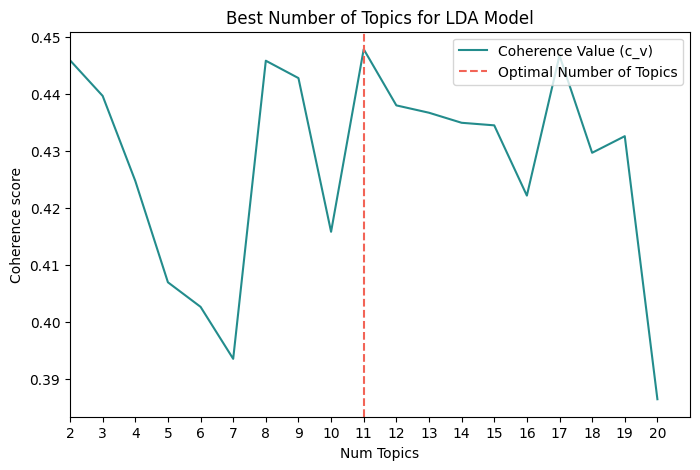

In [72]:
plt.figure(figsize=(8,5))

# Create a custom x-axis
x = range(start, limit, step)

# Build the line plot
ax = sns.lineplot(x=x, y=coherence_values, color='#238C8C')

# Set titles and labels
plt.title("Best Number of Topics for LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.xlim(start, limit)
plt.xticks(range(2, limit, step))

# Add a vertical line to show the optimum number of topics
plt.axvline(x[np.argmax(coherence_values)],
            color='#F26457', linestyle='--')

# Draw a custom legend
legend_elements = [Line2D([0], [0], color='#238C8C',
                          ls='-', label='Coherence Value (c_v)'),
                   Line2D([0], [1], color='#F26457',
                          ls='--', label='Optimal Number of Topics')]

ax.legend(handles=legend_elements, loc='upper right')

In [78]:
best_num_topics = x[np.argmax(coherence_values)]
print(best_num_topics)

11


In [80]:
temp = dictionary[0]
id2word = dictionary

model = LdaModel(
    corpus=corpus,
    id2word=id2word,
    chunksize=2000,
    alpha='auto',
    eta='auto',
    iterations=100,
    num_topics=best_num_topics,
    passes=6,
    eval_every=None)

pyLDAvis.enable_notebook()

# feed the LDA model into the pyLDAvis instance
lda_viz = gensimvis.prepare(model, corpus, dictionary, sort_topics=True)

pyLDAvis.display(lda_viz)

2024-06-12 16:03:15,066 : INFO : using autotuned alpha, starting with [0.09090909, 0.09090909, 0.09090909, 0.09090909, 0.09090909, 0.09090909, 0.09090909, 0.09090909, 0.09090909, 0.09090909, 0.09090909]
2024-06-12 16:03:15,070 : INFO : using serial LDA version on this node
2024-06-12 16:03:15,090 : INFO : running online (multi-pass) LDA training, 11 topics, 6 passes over the supplied corpus of 2760 documents, updating model once every 2000 documents, evaluating perplexity every 0 documents, iterating 100x with a convergence threshold of 0.001000
2024-06-12 16:03:15,090 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2024-06-12 16:03:15,097 : INFO : PROGRESS: pass 0, at document #2000/2760
2024-06-12 16:03:15,097 : DEBUG : performing inference on a chunk of 2000 documents
2024-06-12 16:03:32,464 : DEBUG : 4/2000 documents converged within 100 iterations
2024-06-12 16:03:32,471 : INFO : optimized alpha [

In [46]:
# TF-IDF vectorization
# from sklearn.feature_extraction.text import TfidfVectorizer

# tfidf_vectorizer = TfidfVectorizer(max_df=0.85, min_df=2, max_features=1000)
# tfidf_matrix = tfidf_vectorizer.fit_transform(df['Clean_Content'])

In [47]:
# from tkinter.constants import N
# from sklearn.decomposition import LatentDirichletAllocation

# def process_and_analyze(n):
#   num_topics = n  # Choose the number of topics
#   lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
#   lda.fit(tfidf_matrix)

#   # Extract topics
#   def display_topics(model, feature_names, no_top_words):
#       topics = []
#       for topic_idx, topic in enumerate(model.components_):
#           topic_terms = [feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]
#           topics.append(topic_terms)
#           print(f"Topic {topic_idx}: {' '.join(topic_terms)}")
#       return topics

#   tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
#   topics = display_topics(lda, tfidf_feature_names, 20)
#   return topics, lda

In [48]:
# from gensim.corpora import Dictionary
# from gensim.models.coherencemodel import CoherenceModel

In [49]:
# def coherence_score(df, topics):
#   dictionary = Dictionary(df['Clean_Content'].apply(lambda x: x.split()).tolist())

#   # Calculate coherence score
#   coherence_model = CoherenceModel(topics=topics, texts=df['Clean_Content'].apply(lambda x: x.split()).tolist(), dictionary=dictionary, coherence='c_v')
#   coherence_score = coherence_model.get_coherence()

#   return coherence_score

In [50]:
# def plot_topic_trends(n, df, lda):
#   pyLDAvis.enable_notebook()
#   panel = pyLDAvis.lda_model.prepare(lda, tfidf_matrix, tfidf_vectorizer, mds='tsne')
#   pyLDAvis.display(panel)

#   # Analyze trends over time
#   df['Topic'] = lda.transform(tfidf_matrix).argmax(axis=1)

#   # Group by date and calculate the mean topic distribution
#   topic_trends = df.groupby(df['Date'].dt.to_period('M')).Topic.value_counts(normalize=True).unstack().fillna(0)

#   # Plot the trends
#   topic_trends.plot(kind='line', figsize=(12, 8))
#   plt.title('Topic Trends Over Time')
#   plt.xlabel('Date')
#   plt.ylabel('Proportion of Documents')
#   plt.legend(title='Topic')
#   plt.show()

In [52]:
# scores = []
# for i in range(2, 10):
#     print(i)
#     topics,_ = process_and_analyze(i)
#     score = coherence_score(df, topics)
#     scores.append(score)
# plt.plot(range(2, 10), scores)
# plt.xlabel("Number of Topics")
# plt.ylabel("Coherence Score")
# plt.title("Coherence Scores by Number of Topics")
# plt.show()